In [1]:
%matplotlib inline
import numpy as np
import pathlib as pl
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import rasterio.warp
from shapely.geometry import shape

import scipy.sparse as sparse

import flopy
import flopy.plot.styles as styles

from gdptools import WeightGenP2P

In [2]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, get_sfincs_grid_name, get_sfincs_dtuser

In [3]:
control_path = pl.Path("../sfincs/test_north_fork/run/sfincs.inp") # change this if using a different D-Flow FM control file
grid_name = get_sfincs_grid_name(control_path)
print(grid_name)

sfincs


In [4]:
# use an output file because this is what will be available from bmi and is in the correct order
source_path = "../sfincs/test_north_fork/run/sfincs_map.nc"
source_ds = xugrid.open_dataset(source_path)

In [5]:
source_ds

<xarray.Dataset> Size: 4GB
Dimensions:        (nmesh2d_node: 56192, nmesh2d_face: 14048, time: 25921,
                    runtime: 1)
Coordinates:
  * time           (time) datetime64[ns] 207kB 2010-01-01 ... 2010-04-01
  * nmesh2d_face   (nmesh2d_face) int64 112kB 0 1 2 3 ... 14045 14046 14047
  * nmesh2d_node   (nmesh2d_node) int64 450kB 0 1 2 3 ... 56189 56190 56191
Dimensions without coordinates: runtime
Data variables:
    inp            int32 4B ...
    mesh2d_node_x  (nmesh2d_node) float32 225kB ...
    mesh2d_node_y  (nmesh2d_node) float32 225kB ...
    crs            int32 4B ...
    zb             (nmesh2d_face) float32 56kB ...
    msk            (nmesh2d_face) float64 112kB ...
    zs             (time, nmesh2d_face) float32 1GB ...
    u              (time, nmesh2d_face) float32 1GB ...
    v              (time, nmesh2d_face) float32 1GB ...
    total_runtime  (runtime) float32 4B ...
    average_dt     (runtime) float32 4B ...
    status         (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.8 UGRID-1.0 Delt...
    Build-Revision-Date-Netcdf-library:  4.8.1 of Sep 29 2021 09:36:14 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: v2.0.8-beta
    Build-Date:                          $Date: 2024-06-10
    title:                               SFINCS map netcdf output

In [6]:
source_gdf = source_ds["nmesh2d_face"].ugrid.to_geodataframe(name="cell")

In [7]:
source_gdf.set_crs(32618, inplace=True)

,cell,geometry
nmesh2d_face,,
0,0,"POLYGON ((575000.000 4477000.000, 576600.000 4..."
1,1,"POLYGON ((575000.000 4478600.000, 576600.000 4..."
2,2,"POLYGON ((575000.000 4480200.000, 576600.000 4..."
3,3,"POLYGON ((575000.000 4481800.000, 576600.000 4..."
4,4,"POLYGON ((575000.000 4483400.000, 576600.000 4..."
...,...,...
14043,14043,"POLYGON ((724200.000 4558000.000, 724400.000 4..."
14044,14044,"POLYGON ((724400.000 4557400.000, 724600.000 4..."
14045,14045,"POLYGON ((724400.000 4557600.000, 724600.000 4..."


/Users/jdhughes/miniforge3/envs/liss/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/jdhughes/miniforge3/envs/liss/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: >

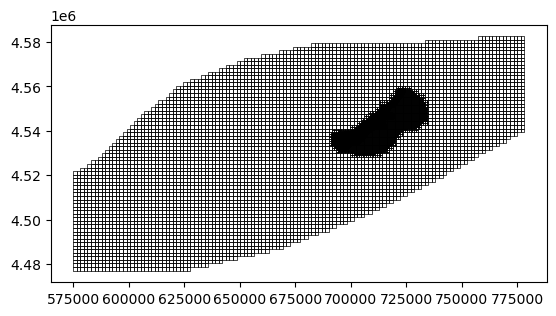

In [8]:
source_gdf.plot(fc="none", ec="black", lw=0.5)

In [9]:
target_coastal = gpd.read_file("../modflow/gis/greenpoint_ghb_utm18n.shp")
target_coastal

,layer,row,column,bhead,cond,iface,boundname,ghb_no,ID,geometry
0,0,26,0,0.0,24999.999994,0,sound,0,1483,"POLYGON ((717047.981 4552610.453, 717192.388 4..."
1,0,27,0,0.0,25000.000000,0,sound,1,1540,"POLYGON ((717096.758 4552466.038, 717241.165 4..."
2,0,28,0,0.0,24999.999994,0,sound,2,1597,"POLYGON ((717145.535 4552321.623, 717289.942 4..."
3,0,29,0,0.0,24231.956659,0,sound,3,1654,"POLYGON ((717194.312 4552177.208, 717338.720 4..."
4,0,25,1,0.0,25000.000006,0,sound,4,1427,"POLYGON ((717143.610 4552803.650, 717288.017 4..."
...,...,...,...,...,...,...,...,...,...,...
730,0,14,56,0.0,22494.219708,0,peconic,730,855,"POLYGON ((724549.547 4557075.386, 724693.965 4..."
731,0,15,56,0.0,25000.000006,0,peconic,731,912,"POLYGON ((724598.333 4556930.967, 724742.751 4..."
732,0,16,56,0.0,24999.999994,0,peconic,732,969,"POLYGON ((724647.119 4556786.547, 724791.537 4..."
733,0,17,56,0.0,25000.000000,0,peconic,733,1026,"POLYGON ((724695.904 4556642.127, 724840.323 4..."


In [10]:
target_coastal.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

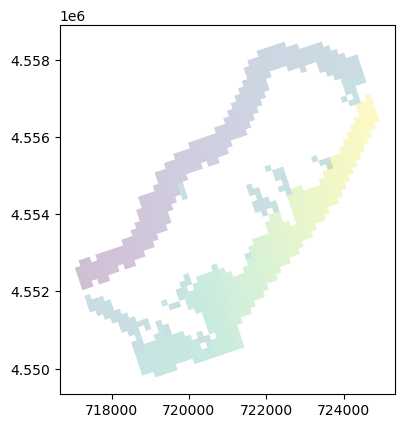

In [11]:
ax = target_coastal.plot(alpha=0.25, column="ghb_no")
# cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

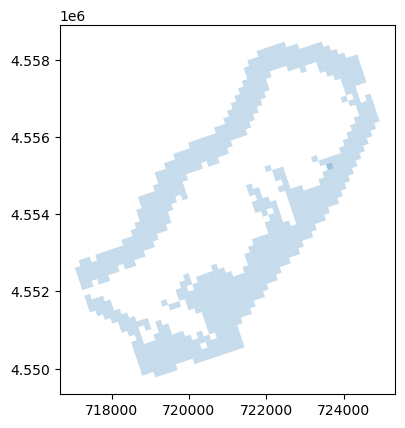

In [12]:
ax = target_coastal.plot(alpha=0.25)
# cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

## Create the SFINCS to GHB mapping

In [13]:
# generate the weights
weight_gen = WeightGenP2P(
    target_poly=target_coastal,
    target_poly_idx="ghb_no",
    source_poly=source_gdf,
    source_poly_idx=["cell"],
    method="serial",
    weight_gen_crs=32618,
)
weights = weight_gen.calculate_weights()

Using serial engine
Reprojecting to epsg:EPSG:32618 finished in 0.0 second(s)
Validating polygons
     - validating source polygons
     - fixing 0 invalid polygons.
     - validating target polygons
     - fixing 0 invalid polygons.
Validate polygons finished in 0.0084 seconds
Intersections finished in 0.0210 seconds
Weight gen finished in 0.0297 seconds


In [14]:
weights[-12:]

,ghb_no,cell,wght
2029,729,7467,0.113080
2030,729,7468,0.886920
2031,730,7423,0.039572
2032,730,7469,0.269532
2033,730,7424,0.140876
2034,730,7470,0.550020
2035,731,7423,0.000197
2036,731,7469,0.999803
2037,732,7469,1.000000
2038,733,7468,0.539402


In [15]:
map_shape = (target_coastal.shape[0], source_gdf.shape[0])
map_shape

(735, 14048)

In [16]:
sfincs2mfghb = np.zeros(map_shape, dtype=float)
print(f"{sfincs2mfghb.shape}\n{sfincs2mfghb}")

(735, 14048)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
sfincs2mfghb[165].sum()

0.0

In [18]:
for r,c,v in zip(weights["ghb_no"], weights["cell"], weights["wght"]):
    sfincs2mfghb[int(r),int(c)] = v

## Create the ghb masking array

Where the sums of the weights along a row are not equal to ~1.0

In [19]:
mask_idx = np.isclose(sfincs2mfghb.sum(axis=1), 1.0)
print(f"{mask_idx.sum()}\n{mask_idx.shape}\n{mask_idx}")

735
(735,)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

### Test the SFINCS to GHB mapping

In [20]:
s = np.full(source_gdf.shape[0], 1.0)
h = np.full(mask_idx.shape, 2.0)
h[mask_idx] = sfincs2mfghb.dot(s)[mask_idx]
s.shape, sfincs2mfghb.shape, h.shape

((14048,), (735, 14048), (735,))

In [21]:
print(f"{h.sum()}\n{h}")

734.999999999983
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

#### Test with a nan

In [22]:
s = np.random.random(source_gdf.shape[0])
s[1544] = -1e30
print(s)

[0.00181847 0.96695987 0.71388734 ... 0.57568552 0.61663775 0.78857022]


In [23]:
h = np.full(mask_idx.shape, 2.0)
h = sfincs2mfghb.dot(s)
h.shape

(735,)

In [24]:
print(f"{h.sum()}\n{h}")

357.17381132724984
[0.21502266 0.02433274 0.04842209 0.71547557 0.81466795 0.48198903
 0.07552241 0.04640194 0.2993665  0.5514185  0.33214407 0.62115927
 0.26641036 0.14554037 0.46719451 0.65599374 0.80760278 0.14554037
 0.16594031 0.4566761  0.5804929  0.44087074 0.13805849 0.50791188
 0.9190591  0.58562026 0.10833366 0.13754003 0.1660486  0.44673347
 0.09005244 0.19229996 0.4155342  0.16300061 0.74931668 0.79831044
 0.71965273 0.37240674 0.52678034 0.84575523 0.94583266 0.78113816
 0.9401467  0.88905056 0.69710715 0.38025535 0.54201239 0.63768737
 0.81006049 0.41876458 0.26568675 0.03109758 0.00516411 0.22615819
 0.90818055 0.54962976 0.37032897 0.37032897 0.12319102 0.00516411
 0.01886684 0.72610299 0.63466482 0.55433978 0.5333402  0.37131375
 0.37198264 0.26183468 0.02098182 0.17603572 0.38774862 0.54397064
 0.46687989 0.29082403 0.30713225 0.41696472 0.24826187 0.32575904
 0.07871492 0.21526348 0.27772559 0.16366843 0.37320414 0.71386144
 0.72374182 0.49365216 0.33370864 0.5609285

## Create the GHB to Qext mapping

In [25]:
ghb2qext = np.transpose(sfincs2mfghb.copy())

### Test the GHB to Qext mapping

In [26]:
q = np.full(ghb2qext.shape[1], 1.0)

In [27]:
qext = ghb2qext.dot(q)

In [28]:
print(f"{qext.sum()}\n{qext.shape}")

734.999999999983
(14048,)


## Save the mapping arrays

In [29]:
fpath = f"../mapping/sfincs2mfghb_{grid_name}.npz"
np.savez_compressed(fpath, sfincs2mfghb=sfincs2mfghb, ghbmask=mask_idx, ghb2qext=ghb2qext)